In [8]:
import os
os.chdir('G:/My Drive/GitHub/VideoDiffusion/')
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We choose to train only "cat" classes in CIFAR10

1.1 Dataset preview

Files already downloaded and verified


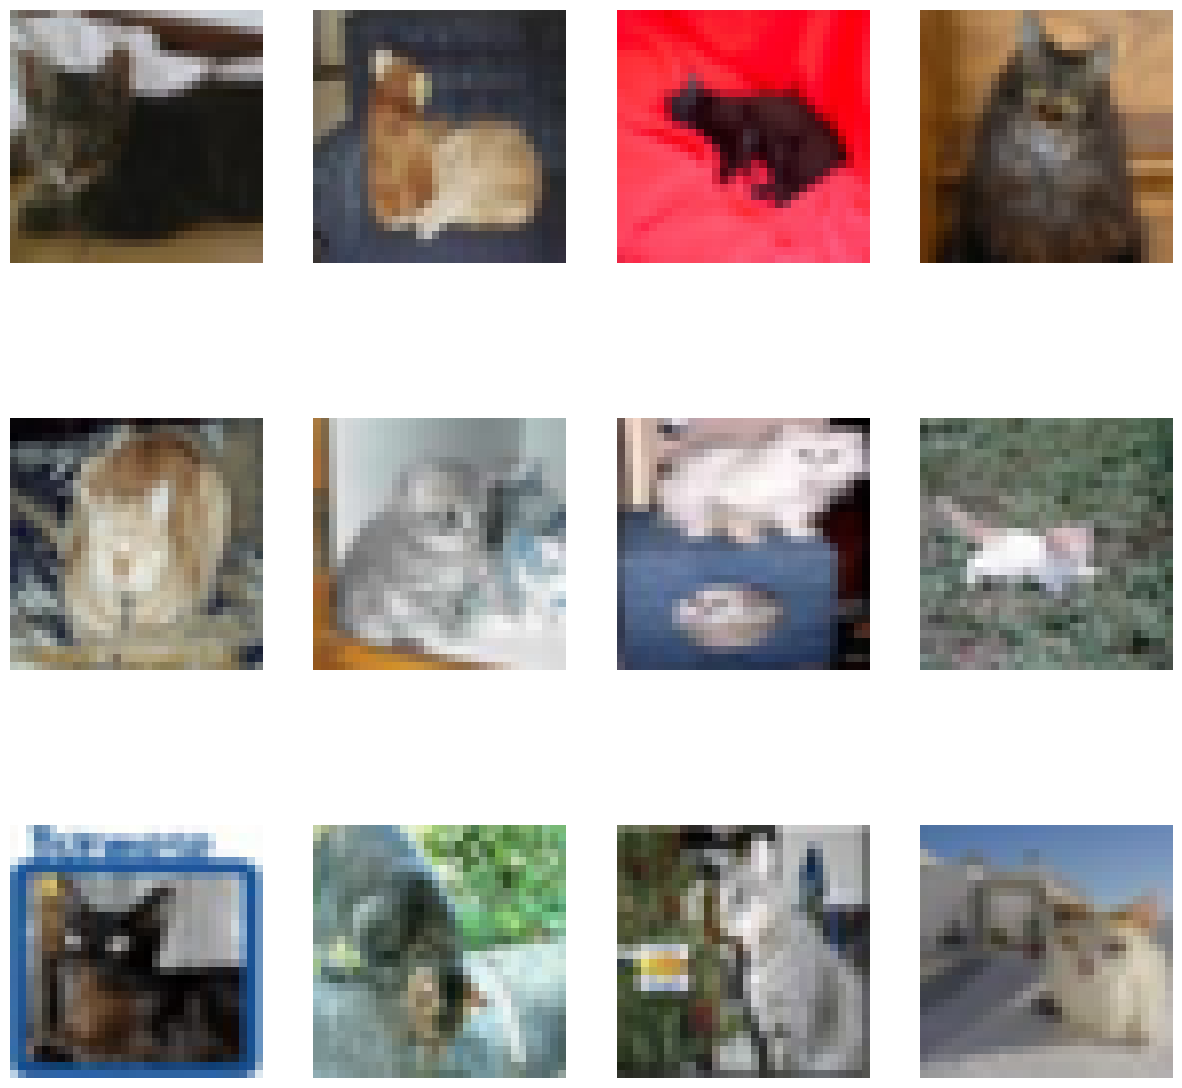

In [6]:
# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(), 
])
all_dataset = torchvision.datasets.CIFAR10(root='./CIFAR', train=True, download=True, transform=transform)

# Get the cat class, and set the correct tensor format
classes = all_dataset.classes
cat_class_index = classes.index('cat')
cat_dataset_pre = [(img, label) for img, label in all_dataset if label == cat_class_index]
cat_dataset = [item[0].permute(1,2,0) for item in cat_dataset_pre]

# Example image plot
def img_plt(imgset, num_samples=12, cols=4):
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(imgset):
        if i == num_samples:
            break
        plt.subplot(num_samples // cols, cols, i+1)
        plt.imshow(img)
        plt.axis('off')
img_plt(cat_dataset)

In [3]:
torch.min(cat_dataset[0])

tensor(0.0431)

1.2 Data loader

In [20]:
from torch.utils.data import DataLoader
from torchvision import transforms

img_size1 = 32
batch_size1 = 100

def load_transform_data():
    data_transform = transforms.Compose([
        transforms.Resize((img_size1, img_size1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
        transforms.Lambda(lambda x: x*2-1 )
    ])
    
    train_set = torchvision.datasets.CIFAR10(root='./CIFAR_train', train=True, download=True, transform=data_transform)
    test_set = torchvision.datasets.CIFAR10(root='./CIFAR_test', train=False, download=True, transform=data_transform)
    total_set = torch.utils.data.ConcatDataset([train_set, test_set])
    return total_set
# since this is a generative AI model, we don't need to split the dataset into train and test

def show_sample_image(image):
    image_transform = transforms.Compose([
        transforms.Lambda(lambda x: (x+1)/2 ),
        transforms.Lambda(lambda x: x.permute(1,2,0) ), # to H,W,C
        transforms.Lambda(lambda x: x*255 ),
        transforms.Lambda(lambda x: x.numpy().astype(np.uint8) ),
        transforms.ToPILImage()
    ])
    
    # For batched dataset
    if len(image.shape) == 4:
        image = image[0,:,:,:]
    plt.imshow(image_transform(image))

data_all = load_transform_data()  
data_cat = [item for item in data_all if item[1] == cat_class_index]
data_loader = DataLoader(data_cat, batch_size=batch_size1, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


2.1  Noise scheduler - Forward process

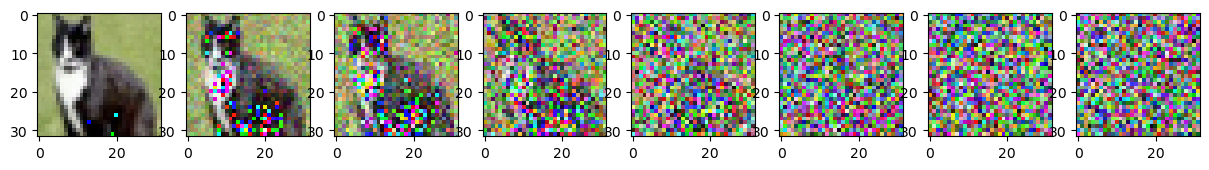

In [27]:
import torch.nn.functional as F

# Define beta, alpha
timesteps = 100
beta_start = 1e-4
beta_end = 2e-2
beta = torch.linspace(beta_start, beta_end, timesteps)

# Define the closed-form scheduler
alpha = 1. - beta
alpha_cumprod = torch.cumprod(alpha, dim=0)
alpha_cumprod_pad1 = F.pad(alpha_cumprod[:-1], (1, 0), value=1.) # let 'alpha list' start from 1, and drop the last element
sqrt_recip_alpha = torch.sqrt(1./alpha)
sqrt_alpha_cumprod = torch.sqrt(alpha_cumprod)
sqrt_oneminus_alpha_cumprod = torch.sqrt(1-alpha_cumprod)
posterior_variance = beta * (1. - alpha_cumprod_pad1) / (1. - alpha_cumprod)

def get_index(list1, t, x_shape):
    batch_size = t.shape[0]
    output = list1.gather(-1,t.cpu())
    return output.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion(x_0, t, device='cpu'):
    noise = torch.randn_like(x_0)
    sqrt_alpha_cumprod_t = get_index(sqrt_alpha_cumprod, t, x_0.shape)
    sqrt_oneminus_alpha_cumprod_t = get_index(sqrt_oneminus_alpha_cumprod, t, x_0.shape)
    x_t = sqrt_alpha_cumprod_t.to(device) * x_0.to(device) + sqrt_oneminus_alpha_cumprod_t.to(device) * noise.to(device)
    return x_t, noise.to(device)



image = next(iter(data_loader))[0] # get the first batch
num_samples = 7
step_size = timesteps//num_samples #100//12=8

plt.figure(figsize=(15, 15))
for i in range(0, timesteps, step_size):
    t = torch.tensor([i]).type(torch.long)
    plt.subplot(1, num_samples+1, i//step_size+1) # start from x_0 (uncorrupted), so +1
    img, noise = forward_diffusion(image, t)
    show_sample_image(img)

2.2 U-Net: Backword process